In [17]:
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [18]:
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Downsample from 28x28 to 16x16
    transforms.ToTensor()
])

batch_size = 64

mnist_16 = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(mnist_16, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


In [21]:
mnist_16

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(16, 16), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Labels:  tensor([6, 2, 9, 4, 2, 8, 3, 5, 7, 4, 7, 2, 0, 8, 7, 2, 3, 5, 3, 6, 1, 6, 7, 1,
        0, 7, 2, 8, 6, 1, 7, 0, 6, 1, 4, 2, 3, 0, 7, 0, 3, 6, 4, 3, 8, 5, 7, 9,
        4, 2, 9, 2, 3, 5, 4, 6, 8, 4, 7, 6, 7, 1, 4, 5])


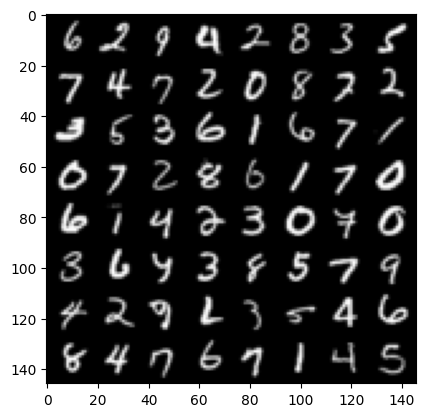

In [19]:
dataiter = iter(loader)
images, labels = next(dataiter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print labels
print('Labels: ', labels)

# show images
imshow(make_grid(images))

In [22]:
# prompt: compute mean across each coordinate of each image in the dataset so the mean tensor should be the same size as an image

# Initialize a tensor to accumulate the sum of images
# Get the shape of a single image from the first batch
first_batch_images, _ = next(iter(loader))
image_shape = first_batch_images[0].shape # (C, H, W)

# Create a tensor of zeros with the same shape as an image
# This will hold the sum of pixel values across all images
sum_of_images = torch.zeros(image_shape)
total_images = 0

# Iterate through the dataset to sum up all images
for images, _ in loader:
    sum_of_images += torch.sum(images, dim=0)
    total_images += images.size(0)

# Compute the mean image by dividing the sum by the total number of images
mean_image = sum_of_images / total_images

Mean Image:


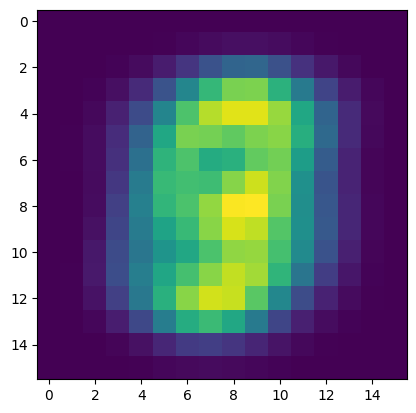

In [23]:
# prompt: display the mean image

# The mean tensor is already computed and stored in 'mean_image'
# We need to display this mean image.
# The imshow function expects a tensor with shape (C, H, W), which 'mean_image' already is.
# We can directly pass 'mean_image' to the imshow function.

# Ensure mean_image is on the CPU before converting to numpy
if mean_image.is_cuda:
    mean_image = mean_image.cpu()

# Display the mean image
print('Mean Image:')
imshow(mean_image)

In [24]:
#ensure the mean we computed is correct -- sanity check

# Initialize a tensor to accumulate the sum of images
# Get the shape of a single image from the first batch
first_batch_images, _ = next(iter(loader))
image_shape = first_batch_images[0].shape # (C, H, W)

# Create a tensor of zeros with the same shape as an image
# This will hold the sum of pixel values across all images
sum_of_images = torch.zeros(image_shape)
total_images = 0

# Iterate through the dataset to sum up all images
for images, _ in loader:
    sum_of_images += torch.sum(images, dim=0) - images.size(0) * mean_image
    total_images += images.size(0)

# Compute the mean image by dividing the sum by the total number of images

origin = sum_of_images / total_images
print(torch.mean(origin))
print(torch.std(origin))


tensor(1.6604e-09)
tensor(8.2539e-08)


In [49]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, time_emb_dim = 32, out_channels=1):
        super().__init__()


        # Time embedding layers
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.channel_size = [32, 64, 64]

        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, self.channel_size[0], kernel_size=5, padding=2),
            nn.Conv2d(32, self.channel_size[1], kernel_size=5, padding=2),
            nn.Conv2d(64, self.channel_size[2], kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

        self.time_proj = nn.ModuleList([
            nn.Linear(time_emb_dim, 32),  # after first conv
            nn.Linear(time_emb_dim, 64),  # after second conv
            nn.Linear(time_emb_dim, 64),  # after third conv
        ])

    def forward(self, x, t):
        if t.ndim == 1:
            t = t[:, None]  # Ensure shape (B, 1)
        temb = self.time_mlp(t)  # (B, time_emb_dim)

        h = []
        for i, l in enumerate(self.down_layers):
            time_feature = self.time_proj[i](temb).view(-1, self.channel_size[i], 1, 1)
            x = self.act(l(x) + time_feature) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [47]:
def corrupt(x, t, std_dev):
  """Generate the noise given input `x` and time t and the std dev"""
  noise = std_dev * torch.sqrt(torch.tensor(t, device=x.device, dtype=x.dtype)) * torch.randn_like(x)
  return x + noise

Finished epoch 0. Average loss for this epoch: 0.030266
Finished epoch 1. Average loss for this epoch: 0.026319
Finished epoch 2. Average loss for this epoch: 0.025028
Finished epoch 3. Average loss for this epoch: 0.025050
Finished epoch 4. Average loss for this epoch: 0.024784
Finished epoch 5. Average loss for this epoch: 0.024668
Finished epoch 6. Average loss for this epoch: 0.024841
Finished epoch 7. Average loss for this epoch: 0.024673
Finished epoch 8. Average loss for this epoch: 0.024439
Finished epoch 9. Average loss for this epoch: 0.024493


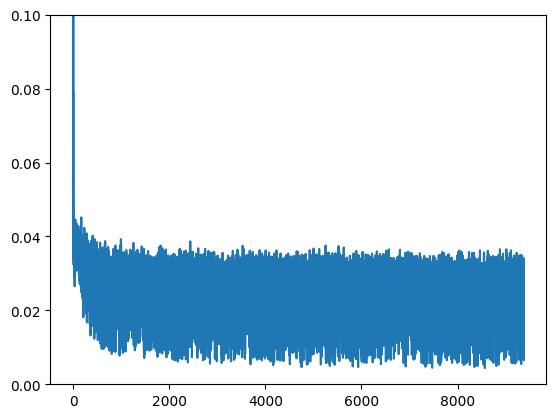

In [50]:
n_epochs = 10
terminal_variance = 2
# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs): #num of passes thru dataset

    for x, y in loader: #loop thru each batch that collectively comprise a dataset

        x = x - mean_image # center the batch ariund the origin
        x = x.to(device) # move data to the GPU
        t = np.random.uniform(size=1)
        noisy_x = corrupt(x, t, terminal_variance ** 0.5) # Create our noisy x; same size as x
        t = torch.ones(size=(x.shape[0],)) * t[0]
        t = t.to(device)

        # Get the model prediction
        pred = net(noisy_x, t)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item()) #for each batch, store the loss

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(loader):])/len(loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

In [ ]:
num_steps = 1000000
delta_t = 1/num_steps
x_1 = torch.randn(1, 1, 16, 16).to(device)

step_times = list(torch.linspace(0, 1, num_steps+1))[1:]
step_times.reverse()

x = x_1
for t in step_times:
  x = x.to(device)
  t = torch.ones(size=(x.shape[0],)) * t
  t = t.to(device)
  with torch.no_grad():
    pred = net(x, t)
  eta = pred - x
  x += (1/t) * eta * delta_t + torch.randn_like(x) * (terminal_variance ** 0.5) * (delta_t ** 0.5)

#add back mean image

x += mean_image
imshow(mean_image)